# Комп’ютерний практикум 9. Розпізнавання рукописних чисел згортковою нейронною мережею.

In [1]:
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels
print(len(y_train), len(y_test))

60000 10000


/home/sashatr/Desktop/projects/education/labs/venv/lib/python3.6/site-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/sashatr/Desktop/projects/education/labs/venv/lib/python3.6/site-packages/torchvision/datasets/mnist.py:45: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/sashatr/Desktop/projects/education/labs/venv/lib/python3.6/site-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/sashatr/Desktop/projects/education/labs/venv/lib/python3.6/site-packages/torchvision/datasets/mnist.py:50: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


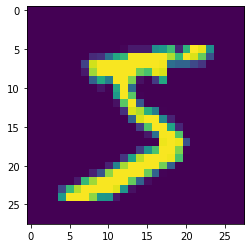

tensor(5)


In [4]:
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [5]:
print(X_train.shape)
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()
print(X_train.shape)

torch.Size([60000, 28, 28])
torch.Size([60000, 1, 28, 28])


In [6]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1 = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2 = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = torch.nn.Tanh()

        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = torch.nn.Tanh()

        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x
    

lenet5 = LeNet5()

## Завдання. Підберіть параметри паденгу

In [7]:
N = 4
C = 3
C_out = 10
H = 8
W = 16

In [8]:
x = torch.ones((N, C, H, W))
out = torch.nn.Conv2d(C, C_out, kernel_size=(3, 3), padding=1)(x)
print(out.shape) # torch.Size([4, 10, 8, 16])

torch.Size([4, 10, 8, 16])


In [9]:
out = torch.nn.Conv2d(C, C_out, kernel_size=(5, 5), padding=2)(x)
print(out.shape) # torch.Size([4, 10, 8, 16])

torch.Size([4, 10, 8, 16])


In [10]:
out = torch.nn.Conv2d(C, C_out, kernel_size=(7, 7), padding=3)(x)
print(out.shape) # torch.Size([4, 10, 8, 16])

torch.Size([4, 10, 8, 16])


In [11]:
out = torch.nn.Conv2d(C, C_out, kernel_size=(9, 9), padding=4)(x)
print(out.shape) # torch.Size([4, 10, 8, 16])

torch.Size([4, 10, 8, 16])


In [12]:
out = torch.nn.Conv2d(C, C_out, kernel_size=(3, 5), padding=(1, 2))(x)
print(out.shape) # torch.Size([4, 10, 8, 16])

torch.Size([4, 10, 8, 16])


In [13]:
out = torch.nn.Conv2d(C, C_out, kernel_size=(3, 3), padding=8)(x)
print(out.shape) # torch.Size([4, 10, 22, 30])

torch.Size([4, 10, 22, 30])


In [14]:
out = torch.nn.Conv2d(C, C_out, kernel_size=(4, 4), padding=1)(x)
print(out.shape) # torch.Size([4, 10, 7, 15])

torch.Size([4, 10, 7, 15])


In [15]:
out = torch.nn.Conv2d(C, C_out, kernel_size=(2, 2), padding=1)(x)
print(out.shape) # torch.Size([4, 10, 9, 17])

torch.Size([4, 10, 9, 17])


## Навчання

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [17]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [18]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch)
        loss_value = loss(preds, y_batch)

        loss_value.backward()
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    if epoch % 10 == 0:
        print(epoch, accuracy)

0 tensor(0.9761)
10 tensor(0.9878)
20 tensor(0.9878)
30 tensor(0.9889)
40 tensor(0.9890)
50 tensor(0.9904)
60 tensor(0.9907)
70 tensor(0.9898)
80 tensor(0.9893)
90 tensor(0.9898)


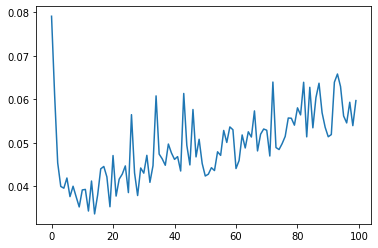

In [19]:
lenet5.forward(X_test)
plt.plot(test_loss_history);

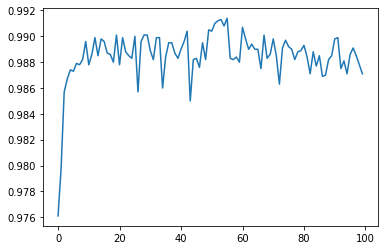

In [20]:
plt.plot(test_accuracy_history);

## Завдання 

1) Спробуйте домогтися якості 0.992 на даному датасета (в максимумі на
валідації). Зверніть увагу на наступні моменти:
Чи з'являється у вас перенавчання при збільшенні кількості епох?
Як додавання різних шарів впливає на швидкість навчання (які шарів швидше:
згорткові або повнозв'язні)?
Пам'ятайте, що результат навчання може змінюватися в від запуску до запуску.
Проаналізуйте дисперсію цільової метрики від запуску до запуску. Скільки
запусків досить зробити, перед тим як стверджувати, що одна архітектура краща
за іншу?

2) Спробуйте аналогічні розрахунки для датасету CIFAR10. Використовуйте
інформацію про датасет з минулої роботи. Змінить нашу мережу LeNet таким
чином, щоб вона приймала зображення 32 на 32 і три канали на вході. Щоб
передати їй три канали, потрібно в in_chanels першої ж згортки поставити "3"
(раніше тут було "1"). А ось розмірність 32 на 32 у нас виходить з паддінга. Як
ви пам'ятаєте, в оригінальному LeNet була розмірність 32 на 32 і там були
нульові паддінгі, тобто згортка не виходили за зображення. Ми навмисно, в
LeNet, для MNIST це змінювали, щоб у нас перша згортка виходила за
зображення і після першої згортки було 28 на 28. А тепер ми, навпаки, хочемо
щоб паддінга не було, і з розмірності 32 на 32 виходила розмірність 28 на 28.
Відповідно, необхідно поставити паддінг "0". Більше нічого не змінюється -
процес навчання не змінюється, він залишився таким же, як і раніше.

3) Знайдіть оптимальну кількість епох для навчання, аналізуючи графіки втрат.